<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Все-функции" data-toc-modified-id="Все-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Все функции</a></span><ul class="toc-item"><li><span><a href="#Функции-перевода-изображения-в-монохромный-формат." data-toc-modified-id="Функции-перевода-изображения-в-монохромный-формат.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Функции перевода изображения в монохромный формат.</a></span></li><li><span><a href="#Функции-resize-и-warp" data-toc-modified-id="Функции-resize-и-warp-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функции resize и warp</a></span></li><li><span><a href="#Функции-рисования-изображений" data-toc-modified-id="Функции-рисования-изображений-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Функции рисования изображений</a></span></li></ul></li><li><span><a href="#Использование-функции-warp" data-toc-modified-id="Использование-функции-warp-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Использование функции warp</a></span><ul class="toc-item"><li><span><a href="#Горизонтальный-warp" data-toc-modified-id="Горизонтальный-warp-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Горизонтальный warp</a></span></li><li><span><a href="#Вертикальный-warp" data-toc-modified-id="Вертикальный-warp-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Вертикальный warp</a></span></li></ul></li><li><span><a href="#Через-ближайший-пиксель" data-toc-modified-id="Через-ближайший-пиксель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Через ближайший пиксель</a></span></li><li><span><a href="#Монохромные-варианты-warp" data-toc-modified-id="Монохромные-варианты-warp-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Монохромные варианты warp</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time as tm

from skimage import io, color, img_as_float
from scipy.ndimage import map_coordinates
import cv2 

# img_as_float переводит имзображение в численное представление
# https://chat.openai.com/share/79755115-6b91-416e-ab70-b069c432674a
# здесь не используем



# from IPython.display import display, Image
# оставлю закомменченым,  для показа используем imshow

# Все функции

## Функции перевода изображения в монохромный формат. 
А также функции умножения матрицы на транспонированную и различных нормализаций. 
Вдруг понадобятся ;-) 

In [2]:
t1_itogo = tm.time()


def monochrome(rgb_image):
    coeffs = np.array([0.299, 0.587, 0.114]) #!!! Не переводим элементы вектора в формат unit8
    return rgb_image @ coeffs


def resize_and_monochrome (picture, k):
    new_size = (round(picture.shape[1]/k), round(picture.shape[0]/k))
    picture = cv2.resize(picture, new_size, interpolation=cv2.INTER_AREA)
    picture_monochrome = monochrome(picture)
    return picture, picture_monochrome



In [3]:
def normalize_image(im):   
    im_res = im - np.min(im)
    return (1 / np.max(im_res)) * im_res

def norm_columns(x):
    columns_sums = np.sum(x, axis=0)
    columns_sums[columns_sums == 0] = np.finfo(float).eps
    # Убедимся, что нормализация применяется корректно
    return x / columns_sums[np.newaxis, :]

# поправила norm_rows, а то там появляется деление на ноль
def norm_rows(x):
    row_sums = np.sum(x, axis=1)
    # Замена нулей на очень маленькое число, чтобы избежать деления на ноль
    row_sums[row_sums == 0] = np.finfo(float).eps
    return x / row_sums[:, np.newaxis]


def trans_mult(A):
    result = normalize_image(np.dot(monochrome(A), np.transpose(monochrome(A))))
    return result

def trans_mult_norm(A):
    result = normalize_image(np.dot(norm_rows(monochrome(A)), norm_columns(np.transpose(monochrome(A)))))
    return result

def trans_mult_norm_plus_1(A):
    B = A+1
    result = normalize_image(np.dot(norm_rows(monochrome(B)), norm_columns(np.transpose(monochrome(B)))))
    return result

def normalize_image_signed(img):
    img1 = img - np.min(img)
    img2 = (2 / np.max(img1)) * img1
    return img2 - 1


def trans_mult_signed(A):
    B = normalize_image_signed(monochrome(A))
    result = normalize_image(np.dot(B, np.transpose(B)))
    return result

## Функции resize и warp

In [4]:
def warp_horizontal(x, y, knob, xsize, ysize):
    # Функция clip для ограничения значения n в пределах от 1 до nsize
    def clip(n, nsize):
        return max(min(nsize, n), 1)
   
    # Вычисление новой координаты x с учетом knob
    xnew = clip(x + 10 * ((knob - 16) / 16) * np.sin(y / 4), xsize)
    ynew = y
    return xnew, ynew






def warp_vertical(x, y, knob, xsize, ysize):
    # Функция clip для ограничения значения n в пределах от 1 до nsize
    def clip(n, nsize):
        return max(min(nsize, n), 1)
    
    # Вычисление новой координаты x с учетом knob
    ynew = clip(y + 10 * ((knob - 16) / 16) * np.sin(x / 4), ysize)
    xnew = x

    return xnew, ynew


def apply_warp(warp, A, knob):
    if A.ndim == 3: 
        [ysize, xsize, channels] = A.shape
    else:
        [ysize, xsize] = A.shape
        channels = 1
    
    def linear_interpolation(x_y, xsize, ysize, A, channels):
        x, y = x_y
        dx = x % 1
        dy = y % 1
        x_left = int(np.floor(x))
        y_left = int(np.floor(y))
        x_right = min(x_left + 1, xsize-1)
        y_right = min(y_left + 1, ysize-1)
        
        if channels > 1:
            return (A[y_left, x_left, :] * (1 - dx) * (1 - dy) + 
                    A[y_right, x_left, :] * (1 - dx) * dy + 
                    A[y_left, x_right, :] * dx * (1 - dy) + 
                    A[y_right, x_right, :] * dx * dy)
        else:
            return (A[y_left, x_left] * (1 - dx) * (1 - dy) + 
                    A[y_right, x_left] * (1 - dx) * dy + 
                    A[y_left, x_right] * dx * (1 - dy) + 
                    A[y_right, x_right] * dx * dy)
    
    result = np.zeros_like(A)
    for x in range(1, xsize + 1):
        for y in range(1, ysize + 1):
            new_x, new_y = warp(x, y, knob, xsize, ysize)  # Передаем xsize и ysize в функцию warp
            if channels > 1:
                result[y - 1, x - 1, :] = linear_interpolation((new_x - 1, new_y - 1), xsize, ysize, A, channels)
            else:
                result[y - 1, x - 1] = linear_interpolation((new_x - 1, new_y - 1), xsize, ysize, A, channels)
    
    return result



In [5]:
# это горизонтальный warp, где у нас не интерполяция, а ближйший пиксель
# работает с warp_horisontal и warp_vertical
# для ускорения
def apply_warp_nearest(warp, A, knob):
    if len(A.shape) == 2:  # Черно-белое изображение
        ysize, xsize = A.shape
        channels = 1
    elif len(A.shape) == 3:  # Цветное изображение
        ysize, xsize, channels = A.shape
    
    # Функция для выбора максимально близкого пикселя через округление
    def nearest_pixel_interpolation(x_y, xsize, ysize):
        x, y = x_y
        x_rounded = int(round(x))
        y_rounded = int(round(y))
        # Ограничение координат в пределах допустимых значений
        x_rounded = max(min(x_rounded, xsize - 1), 0)
        y_rounded = max(min(y_rounded, ysize - 1), 0)
        return A[y_rounded, x_rounded] if channels == 1 else A[y_rounded, x_rounded, :]
    
    # Создание нового изображения с применением искажения и выбором ближайшего пикселя
    result = np.zeros((ysize, xsize, channels), dtype=np.uint8)
    for x in range(1, xsize + 1):
        for y in range(1, ysize + 1):
            new_x, new_y = warp(x, y, knob, xsize, ysize) # Передаем knob и xsize в функцию warp
            # Адаптация координат под нулевую индексацию и запись в result
            result[y - 1, x - 1] = nearest_pixel_interpolation((new_x - 1, new_y - 1), xsize, ysize)
    
    return result

## Функции рисования изображений

In [6]:
# сделаем рисование трех картинок конкретной выбранной функцией warp
# непонятно, получится ли, потому что у кругового wrap другиме параметры. Возможно придется переписывать, 
# а picture_warp можно будет использовать для вертикального и горизонтального warp

def wrap_text(text, max_length):
   
    if len(text) <= max_length:
        return text
    # Находим пробел ближайший к середине строки для красивого переноса
    split_points = [i for i, char in enumerate(text) if char == ' ']
    best_split = min(split_points, key=lambda x: abs(x - max_length))
    return text[:best_split] + '\n' + wrap_text(text[best_split+1:], max_length)


def picture_warp (kind_warp, warp_name, knob, A, B, C, A_name, B_name, C_name):
   
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 14))
    plt.subplots_adjust(hspace=0.3)
    axes[0,0].imshow(A, cmap='gray')
    axes[0,0].set_title(A_name)
# Включение сетки
    axes[0,0].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[0,1].imshow(B, cmap='gray')
    axes[0,1].set_title(B_name)
# Включение сетки
    axes[0,1].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[0,2].imshow(C, cmap='gray')
    axes[0,2].set_title(C_name)
# Включение сетки
    axes[0,2].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    fig.text(0.5, 0.5, f'Pictures after {warp_name}\n', 
         ha='center', va='center', fontsize=15)

    
    axes[1,0].imshow(apply_warp(kind_warp, A, knob), cmap='gray')
    axes[1,0].set_title(wrap_text(f'{A_name} after \n{warp_name}', 45))
# Включение сетки
    axes[1,0].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)


    
    axes[1,1].imshow(apply_warp(kind_warp, B, knob), cmap='gray')
    axes[1,1].set_title(wrap_text(f'{B_name} after \n{warp_name}', 45))
    axes[1,1].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[1,2].imshow(apply_warp(kind_warp, C, knob), cmap='gray')
    axes[1,2].set_title(wrap_text(f'{C_name} after \n{warp_name}', 45))

    axes[1,2].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)
    
    # Отображение фигуры с подграфиками
    plt.show()



# Использование функции warp

## Горизонтальный warp

(444, 250)


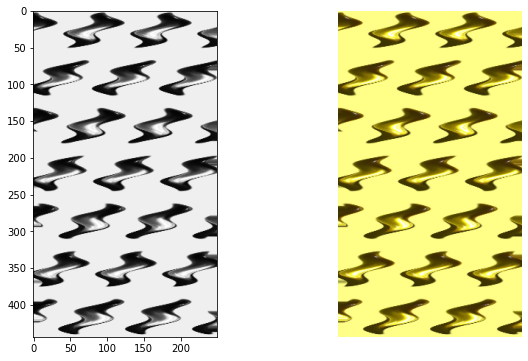

CPU times: total: 3.31 s
Wall time: 3.66 s


In [7]:
%%time
# проверяем, что функция горизонтального warp работает и на монохромных, и на цветных картинках

yellow_raw = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')


yellow_raw, yellow = resize_and_monochrome (yellow_raw, 2)

print(yellow.shape)
    
knob = 35
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(apply_warp(warp_horizontal, yellow, knob), cmap = 'gray')
plt.axis('off')

axes[1].imshow(apply_warp(warp_horizontal, yellow_raw, knob), cmap = 'gray')
plt.axis('off')

plt.show()

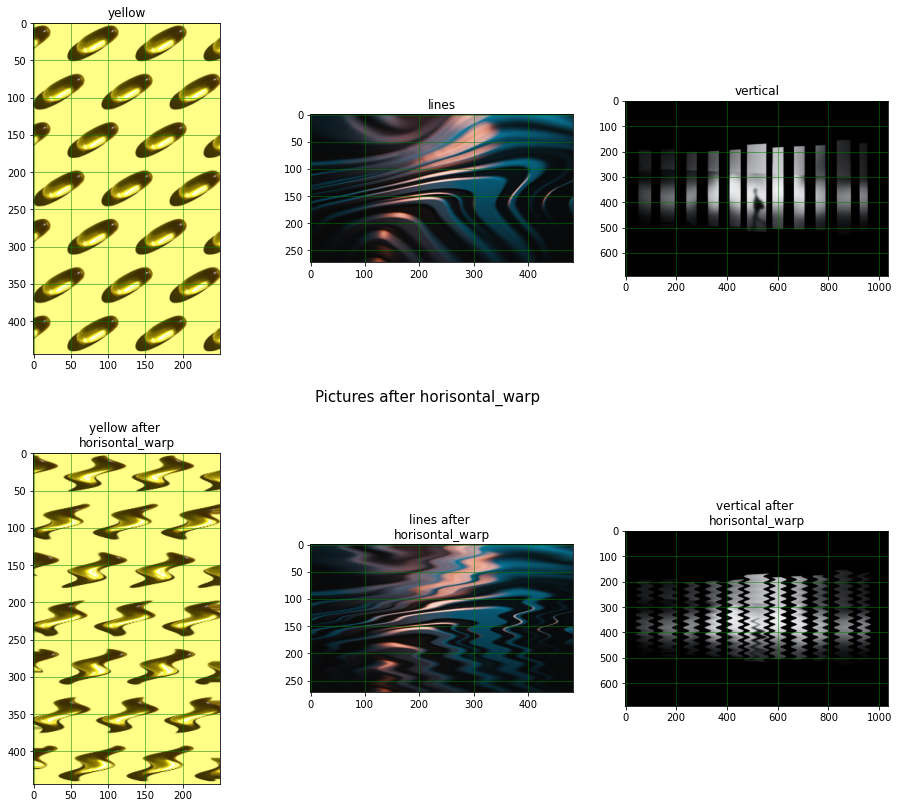

CPU times: total: 23.6 s
Wall time: 24.7 s


In [8]:
%%time
# теперь смотрим на трех картинках (нро только цветной вариант) 
# синтаксис вот такой picture_warp (kind_warp, warp_name, knob, A, B, C, A_name, B_name, C_name)

yellow_raw = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')
lines_raw = io.imread('https://images.unsplash.com/photo-1704520355609-c62b0c4010df?q=80&w=1932&auto=format'
                  '&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')
vertical_raw = io.imread('https://images.unsplash.com/photo-1499428665502-503f6c608263?q=80&w=2070&auto=format&fit=crop&ixlib'
                         '=rb-4.0.3,&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

yellow_raw, yellow = resize_and_monochrome (yellow_raw, 2)
lines_raw, lines = resize_and_monochrome (lines_raw, 4)
vertical_raw, vertical = resize_and_monochrome (vertical_raw, 2)

picture_warp (warp_horizontal, 'horisontal_warp', 35, yellow_raw, lines_raw, vertical_raw, 'yellow', 'lines', 'vertical')




## Вертикальный warp

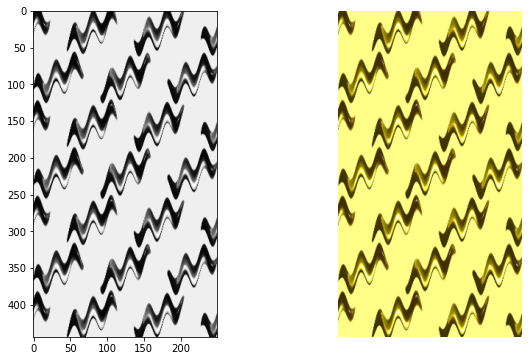

CPU times: total: 4.05 s
Wall time: 4.58 s


In [9]:
%%time
yellow_raw = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')


yellow_raw, yellow = resize_and_monochrome (yellow_raw, 2)
    
knob = 35
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(apply_warp(warp_vertical, yellow, knob), cmap = 'gray')
plt.axis('off')

axes[1].imshow(apply_warp(warp_vertical, yellow_raw, knob), cmap = 'gray')
plt.axis('off')

plt.show()

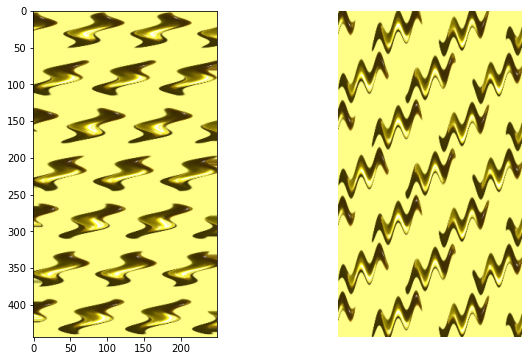

CPU times: total: 5.52 s
Wall time: 5.89 s


In [10]:
%%time

yellow_raw = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')


yellow_raw, yellow = resize_and_monochrome (yellow_raw, 2)
    
knob = 35
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(apply_warp(warp_horizontal, yellow_raw, knob), cmap = 'gray')
plt.axis('off')

axes[1].imshow(apply_warp(warp_vertical, yellow_raw, knob), cmap = 'gray')
plt.axis('off')

plt.show()

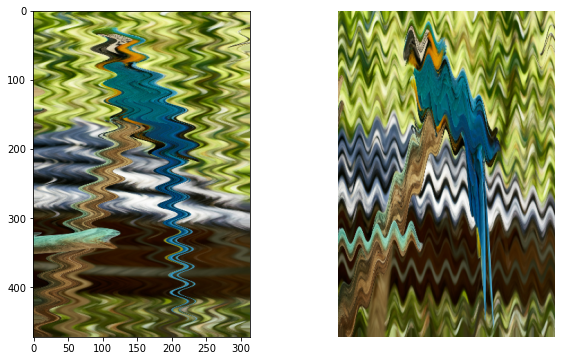

CPU times: total: 7.86 s
Wall time: 8.41 s


In [11]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)

knob = 35
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(apply_warp(warp_horizontal, parrot_raw, knob), cmap = 'gray')
plt.axis('off')

axes[1].imshow(apply_warp(warp_vertical, parrot_raw, knob), cmap = 'gray')
plt.axis('off')

plt.show()

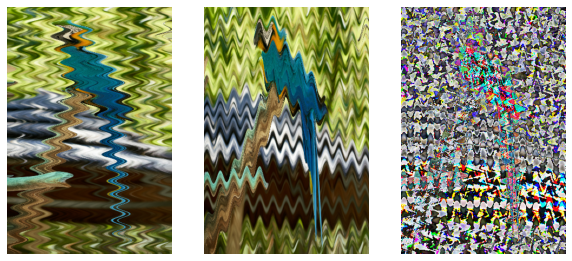

CPU times: total: 8.02 s
Wall time: 8.53 s


In [12]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)

knob = 35
fig, axes = plt.subplots(1, 3, figsize=(10, 6))


horizontal = apply_warp(warp_horizontal, parrot_raw, knob)
vertical = apply_warp(warp_vertical, parrot_raw, knob)

axes[0].imshow(horizontal, cmap = 'gray')
axes[0].axis('off')

axes[1].imshow(vertical, cmap = 'gray')
axes[1].axis('off')

axes[2].imshow(vertical - horizontal, cmap = 'gray')
    
axes[2].axis('off')

plt.show()

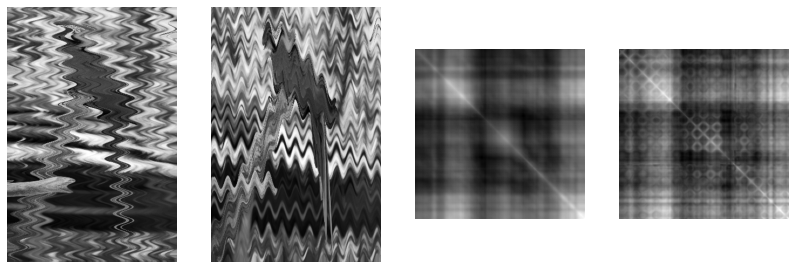

CPU times: total: 4.25 s
Wall time: 4.83 s


In [13]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)

horizontal = apply_warp(warp_horizontal, parrot, knob)
vertical = apply_warp(warp_vertical, parrot, knob)


knob = 35
fig, axes = plt.subplots(1, 4, figsize=(14, 10))

axes[0].imshow(horizontal, cmap = 'gray')
axes[0].axis('off')

axes[1].imshow(vertical, cmap = 'gray')
axes[1].axis('off')

axes[2].imshow(normalize_image(np.dot(np.transpose(horizontal), 
                                      horizontal)), cmap = 'gray')
axes[2].axis('off')


axes[3].imshow(normalize_image(np.dot(np.transpose(vertical), 
                                     vertical)), cmap = 'gray')
axes[3].axis('off')

plt.show()

# Через ближайший пиксель

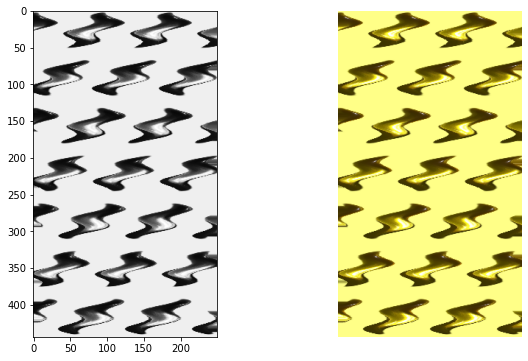

CPU times: total: 1.91 s
Wall time: 2.29 s


In [14]:
%%time
yellow_raw = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')
yellow_raw, yellow = resize_and_monochrome (yellow_raw, 2)
    
knob = 35
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(apply_warp_nearest(warp_horizontal, yellow, knob), cmap = 'gray')
plt.axis('off')

axes[1].imshow(apply_warp_nearest(warp_horizontal, yellow_raw, knob), cmap = 'gray')
plt.axis('off')

plt.show()

Через функцию с интерполяцией эти картинки считались 3,65 секунд, если через ближайший пиксель 2,50 секунд. Разница есть, но всего в полтора раза.

In [15]:
t2_itogo = tm.time()
print('вся тетрадка заняла', round(t2_itogo - t1_itogo)//60,'минут', round(t2_itogo - t1_itogo)%60,'секунд')

вся тетрадка заняла 1 минут 3 секунд


# Монохромные варианты warp

В целом они не улучшили скорость, так что оставляем просто на всякий случай

In [16]:
# горизонтальный warp только для монохромного изображения
# лучше не сделал, так что уберем потом вниз

def warp_horizontal_monochrome(x, y, knob, xsize):
    # Функция clip для ограничения значения n в пределах от 1 до nsize
    def clip(n, nsize):
        return max(min(nsize, n), 1)
    
    # Вычисление новой координаты x с учетом knob
    xnew = clip(x + 10 * ((knob - 16) / 16) * np.sin(y / 4), xsize)
    ynew = y
    return xnew, ynew



def apply_warp_monochrome(warp, A, knob):
    [ysize, xsize] = A.shape # Получение размеров изображения
    
    def linear_interpolation(x_y, xsize, ysize):
        x, y = x_y
        dx = x % 1
        dy = y % 1
        x_left = int(np.floor(x))
        y_left = int(np.floor(y))
        x_right = min(x_left + 1, xsize-1)
        y_right = min(y_left + 1, ysize-1)
        # Вычисление значения нового пикселя через линейную интерполяцию
        return (A[y_left, x_left] * (1 - dx) * (1 - dy) + 
                A[y_right, x_left] * (1 - dx) * dy + 
                A[y_left, x_right] * dx * (1 - dy) + 
                A[y_right, x_right] * dx * dy)
    
    # Создание нового изображения с применением искажения и интерполяции
    result = np.zeros_like(A)
    for x in range(1, xsize + 1):
        for y in range(1, ysize + 1):
            new_x, new_y = warp(x, y, knob, xsize) # Передаем knob и xsize в функцию warp
            # Адаптация координат под нулевую индексацию и запись в result
            result[y - 1, x - 1] = linear_interpolation((new_x - 1, new_y - 1), xsize, ysize)
    
    return result
